![example](images/director_shot.jpeg)

# Microsoft Movie Studios Analysis

**Authors:** Dermot O'Brien, Ziyuan Wang
***

## Overview

We have been tasked with providing the head of "Microsoft Movie Studios" three actionable insights that they can use to decide what kinds of films to make. To make these reccommendations, we must first gather movie data from reputable sources, clean the data properly, and analyze and vizualize our findings simply and effectively.

## Business Problem

Microsoft Movie Studios is a relatively new division that is looking to compete with the best movie makers in the business. To do this, they will first need to have a better understanding of their competitors successes and failures, the trends related to the kinds of movies that are successful, the types of movies that have high production costs and gross profits, etc. In this analysis, we hope to provide a clearer picture of the industry and target an area of focus for Microsoft Movie Studios to take advantage of. 

***
Questions to consider:
* What are the business's pain points related to this project?
* How did you pick the data analysis question(s) that you did?
* Why are these questions important from a business perspective?
***

## Data Understanding

To analyze the movie industry as a whole, we are taking date from the following sources:
- Box Office Mojo
- Rotten Tomatoes
- The Movie Database (TMDB)
- The Numbers
- Internet Movie Database (IMDB)

***
Questions to consider:
* Where did the data come from, and how do they relate to the data analysis questions?
* What do the data represent? Who is in the sample and what variables are included?
* What is the target variable?
* What are the properties of the variables you intend to use?
***

In [2]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from collections import defaultdict

%matplotlib inline

# Create a connection to IMDB Database
conn = sqlite3.connect('./zippedData/im.db')

# Other
pd.options.display.max_rows = 1000

In [3]:
# Here you run your code to explore the data

# Box Office Mojo
bom_df = pd.read_csv('./zippedData/bom.movie_gross.csv.gz')

# Rotten Tomatoes Movies
rt_movie_df = pd.read_csv('./zippedData/rt.movie_info.tsv.gz', delimiter='\t')

# Rotten Tomatoes Reviews
rt_reviews_df = pd.read_csv('./zippedData/rt.reviews.tsv.gz', delimiter='\t', encoding='latin1')

# The Numbers Movie Budgets
tn_moviebudgets_df = pd.read_csv('./zippedData/tn.movie_budgets.csv.gz')

# The Movie Data Base Movies
tmdb_moives_df = pd.read_csv('./zippedData/tmdb.movies.csv.gz') # genre ids?

# IMDB Database (Schema)
imdb_schema = pd.read_sql("""
SELECT *
FROM sqlite_master
""", conn)

## Data Preparation

Describe and justify the process for preparing the data for analysis.

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

### DJ's Data Inspection & Prep on Rotten Tomatoes Data

#### Two Dataframes to work with:

##### Rotten Tomatoes Movies

In [5]:
rt_movie_df.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


In [6]:
rt_movie_df.shape

(1560, 12)

In [7]:
rt_movie_df.describe()

,id
count,1560.000000
mean,1007.303846
std,579.164527
min,1.000000
25%,504.750000
50%,1007.500000
75%,1503.250000
max,2000.000000


In [8]:
rt_movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   currency      340 non-null    object
 9   box_office    340 non-null    object
 10  runtime       1530 non-null   object
 11  studio        494 non-null    object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


In [9]:
rt_movie_df.isna().sum()

id                 0
synopsis          62
rating             3
genre              8
director         199
writer           449
theater_date     359
dvd_date         359
currency        1220
box_office      1220
runtime           30
studio          1066
dtype: int64

##### Rotten Tomatoes Reviews

In [10]:
rt_reviews_df.head()

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


In [11]:
rt_reviews_df.shape

(54432, 8)

In [12]:
rt_reviews_df.describe()

,id,top_critic
count,54432.000000,54432.000000
mean,1045.706882,0.240594
std,586.657046,0.427448
min,3.000000,0.000000
25%,542.000000,0.000000
50%,1083.000000,0.000000
75%,1541.000000,0.000000
max,2000.000000,1.000000


In [13]:
rt_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54432 non-null  int64 
 1   review      48869 non-null  object
 2   rating      40915 non-null  object
 3   fresh       54432 non-null  object
 4   critic      51710 non-null  object
 5   top_critic  54432 non-null  int64 
 6   publisher   54123 non-null  object
 7   date        54432 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.3+ MB


In [14]:
rt_reviews_df.isna().sum()

id                0
review         5563
rating        13517
fresh             0
critic         2722
top_critic        0
publisher       309
date              0
dtype: int64

##### Merge the Dataframes

In [4]:
# Merge the dataframes
rt_full_df = rt_movie_df.merge(rt_reviews_df, how='inner', on='id')

##### Best Genre's according to top critics "fresh" ratings

In [6]:
# Top Critic is a designation created to distinguish Tomatometer-approved critics who excel at their craft. 
# Critics selected are well-established, influential, and prolific; they are, in a sense, the cream of the crop. 
# Top Critic status is granted by a set of criteria and a selection panel and cannot be applied for.

# create a dictionary with k = movie id and v = fresh/total ratio of all "fresh" ratings by critics per movie
movie_fresh_dict = {} 
for movie_id in rt_full_df.groupby(by='id').groups:
    count = rt_full_df.groupby(by='id').get_group(movie_id)['fresh'].value_counts().values.tolist()
    total_count = sum(count)
    if total_count >= 100:
        try:
            ratio = round(count[0] / (count[0] + count[1]), 2)
        except:
            ratio = 1
    else:
        continue
    
    movie_fresh_dict[movie_id] = ratio
#movie_fresh_dict

In [7]:
# filter out rows that have less than 100 fresh ratings
genre_clean = rt_full_df.groupby(by='id').count()
genre_clean = genre_clean.loc[genre_clean['fresh'] > 100]
genre_index_100 = list(genre_clean.index)
genre_df = rt_full_df.loc[rt_full_df['id'].isin(genre_index_100)]

In [8]:
# create a dictionary where k = movie id and v = genre
genre_dict = dict(zip(genre_df.id, genre_df.genre))
#genre_dict

In [11]:
# create a dictionary where k = movie id and v = list that includes the fresh rating and genre
genre_rating_dict = {}

for key in (movie_fresh_dict.keys() | genre_dict.keys()):
    if key in movie_fresh_dict: 
        genre_rating_dict.setdefault(key, []).append(movie_fresh_dict[key])
    if key in genre_dict: 
        genre_rating_dict.setdefault(key, []).append(genre_dict[key])

#genre_rating_dict

In [17]:
# create a dataframe that includes movie id (as index), Fresh Ratio, Genre
genre_rating_df = pd.DataFrame.from_dict(genre_rating_dict, orient='index', columns=['Fresh Ratio', 'Genre']).sort_values(by='Fresh Ratio', ascending=False)
genre_rating_df['Main Genre'] = genre_rating_df['Genre'].str.split("|").str[0]
genre_rating_df.drop(1822, inplace=True)
genre_rating_df

,Fresh Ratio,Genre,Main Genre
1960,0.99,Drama,Drama
1418,0.97,Action and Adventure|Animation|Comedy|Drama|Ki...,Action and Adventure
1208,0.97,Animation|Comedy|Kids and Family,Animation
906,0.96,Drama,Drama
1083,0.96,Comedy|Drama|Romance,Comedy
1579,0.96,Drama,Drama
1976,0.96,Action and Adventure|Art House and International,Action and Adventure
1721,0.95,Comedy|Drama,Comedy
1067,0.95,Drama|Romance,Drama
1112,0.94,Drama,Drama


In [21]:
# Group dataframe by Genre and find the average fresh ratio for each genre
# genre_rating_df.groupby(by='Genre').mean().sort_values(by='Fresh Ratio', ascending=False)

NameError: name 'x' is not defined

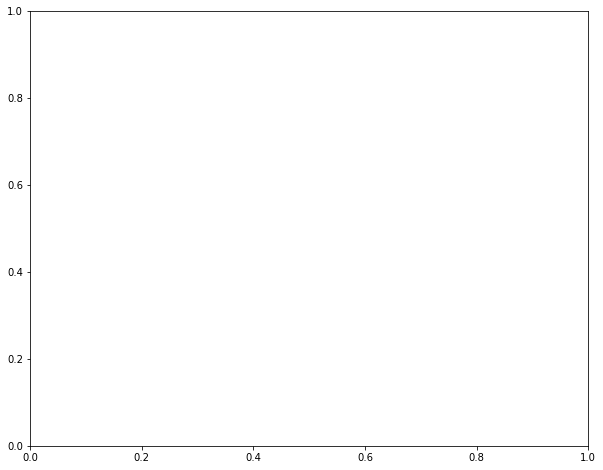

In [22]:
# Create a scatter plot
fig, ax = plt.subplots(figsize = (10,8))

ax.bar(x, y)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('')

##### Best Runtimes according to IMDB ratings

In [23]:
# schema
imdb_schema = pd.read_sql("""
SELECT *
FROM sqlite_master
""", conn)
imdb_schema

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [19]:
random_df = pd.read_sql("""
SELECT *
FROM
    movie_ratings
""", conn)
random_df

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21
...,...,...,...
73851,tt9805820,8.1,25
73852,tt9844256,7.5,24
73853,tt9851050,4.7,14
73854,tt9886934,7.0,5


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt1422020,Dog Pound,Dog Pound,2010,91.0,Drama,7.0,10025
1,tt1549572,Another Earth,Another Earth,2011,92.0,"Drama,Romance,Sci-Fi",7.0,85839
2,tt1655420,My Week with Marilyn,My Week with Marilyn,2011,99.0,"Biography,Drama",7.0,79337
3,tt1228705,Iron Man 2,Iron Man 2,2010,124.0,"Action,Adventure,Sci-Fi",7.0,657690
4,tt1797504,I Want You,Tengo ganas de ti,2012,120.0,"Drama,Romance",7.0,12594
5,tt1219342,Legend of the Guardians: The Owls of Ga'Hoole,Legend of the Guardians: The Owls of Ga'Hoole,2010,97.0,"Action,Adventure,Animation",7.0,73790
6,tt1772288,Danny Collins,Danny Collins,2015,106.0,"Biography,Comedy,Drama",7.0,27435
7,tt1319718,Little Big Soldier,Da bing xiao jiang,2010,96.0,"Action,Adventure,Comedy",7.0,13808
8,tt1563738,One Day,One Day,2011,107.0,"Drama,Romance",7.0,128094
9,tt0790724,Jack Reacher,Jack Reacher,2012,130.0,"Action,Crime,Thriller",7.0,284547


In [21]:
runtime_df = pd.read_sql("""
SELECT *
FROM
    movie_basics as mb
    INNER JOIN movie_ratings as mr
        USING(movie_id)
WHERE numvotes > 10000 and averagerating >= 7.0 -- chose 10,000 so the ratings were significant, less significant the smaller the vote count
ORDER BY averagerating ASC
""", conn)

In [22]:
# drop movies that agreggate multiple parts
runtime_df.loc[runtime_df['runtime_minutes'] > 200]
runtime_df.drop([174, 904, 972], inplace=True)

In [26]:
runtime_df['runtime_minutes'].describe()

count    974.000000
mean     118.239220
std       21.534772
min       45.000000
25%      102.000000
50%      116.000000
75%      132.000000
max      196.000000
Name: runtime_minutes, dtype: float64

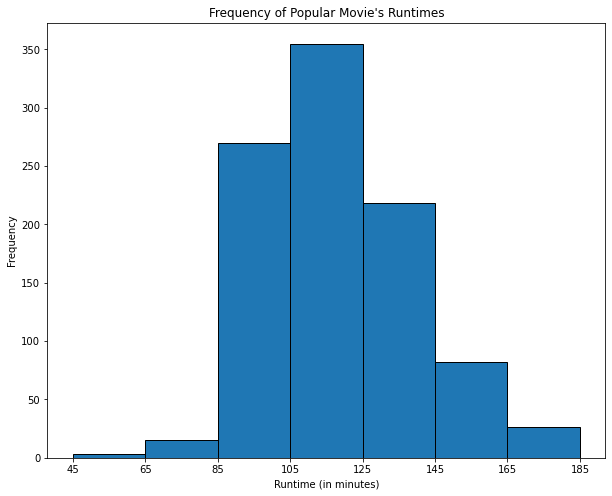

In [37]:
# create a histogram to show frequencies of popular movie's runtimes
x = runtime_df['runtime_minutes']
bin_names = ["45-65","65-85", "85-105", "105-125", "125-145", "145-165", "165-195"]

fig, ax = plt.subplots(figsize=(10,8))

ax.hist(x, bins=range(45, 195, 20), edgecolor='black')
ax.set_xlabel('Runtime (in minutes)')
ax.set_ylabel('Frequency')
ax.set_title("Frequency of Popular Movie's Runtimes")
ax.set_xticks(range(45, 195, 20));
#ax.set_xticklabels(bin_names, rotation=45);

##### Best ___ according to IMDB

In [ ]:
# schema
imdb_schema = pd.read_sql("""
SELECT *
FROM sqlite_master
""", conn)
imdb_schema

In [ ]:
imdb_df1 = pd.read_sql("""
SELECT *
FROM
    movie_basics, movie_ratings
""", conn)
imdb_df1

# Terry Analysis

In [ ]:
im_df.head()

In [ ]:
# split genres
im_df['genres'].str.split(",").str[0]

## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

In [ ]:
# Here you run your code to model the data


## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***